# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip

In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/Kuliah/PERSONAL PROJECTS/ Coffee Bean Class Detection/archive.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed.")

Unzipping completed.


In [3]:
import os

for dirpath, dirnames, filenames in os.walk("/content/data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 1 images in /content/data
There are 4 directories and 0 images in /content/data/train
There are 0 directories and 300 images in /content/data/train/Medium
There are 0 directories and 300 images in /content/data/train/Green
There are 0 directories and 300 images in /content/data/train/Light
There are 0 directories and 300 images in /content/data/train/Dark
There are 4 directories and 0 images in /content/data/test
There are 0 directories and 100 images in /content/data/test/Medium
There are 0 directories and 100 images in /content/data/test/Green
There are 0 directories and 100 images in /content/data/test/Light
There are 0 directories and 100 images in /content/data/test/Dark


There is an 80/20 split for train & test. I will split the test in half creating a 80/10/10 train/test/val split

In [4]:
import shutil
import random
# Paths
test_dir = "data/test"
val_dir = "data/val"
final_test_dir = "data/test"

# Create new directories for val and final_test
os.makedirs(val_dir, exist_ok=True)
os.makedirs(final_test_dir, exist_ok=True)

# For each class, split test images into 50% val and 50% final_test
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)  # shuffle for randomness

        # split in half
        split_idx = len(images) // 2
        val_images = images[:split_idx]
        final_test_images = images[split_idx:]

        # make class subfolders
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(final_test_dir, class_name), exist_ok=True)

        # move files
        for img in val_images:
            shutil.move(os.path.join(class_path, img),
                        os.path.join(val_dir, class_name, img))

        for img in final_test_images:
            shutil.move(os.path.join(class_path, img),
                        os.path.join(final_test_dir, class_name, img))

print("✅ Test set split into validation and final_test sets successfully!")


✅ Test set split into validation and final_test sets successfully!


In [5]:
subsets = ["train","test","val"]

for subset in subsets:
  print(f"Directories & Images in {subset}")
  for dirpath, dirnames, filenames in os.walk(f"/content/data/{subset}"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
  print("\n")

Directories & Images in train
There are 4 directories and 0 images in /content/data/train
There are 0 directories and 300 images in /content/data/train/Medium
There are 0 directories and 300 images in /content/data/train/Green
There are 0 directories and 300 images in /content/data/train/Light
There are 0 directories and 300 images in /content/data/train/Dark


Directories & Images in test
There are 4 directories and 0 images in /content/data/test
There are 0 directories and 50 images in /content/data/test/Medium
There are 0 directories and 50 images in /content/data/test/Green
There are 0 directories and 50 images in /content/data/test/Light
There are 0 directories and 50 images in /content/data/test/Dark


Directories & Images in val
There are 4 directories and 0 images in /content/data/val
There are 0 directories and 50 images in /content/data/val/Medium
There are 0 directories and 50 images in /content/data/val/Green
There are 0 directories and 50 images in /content/data/val/Light


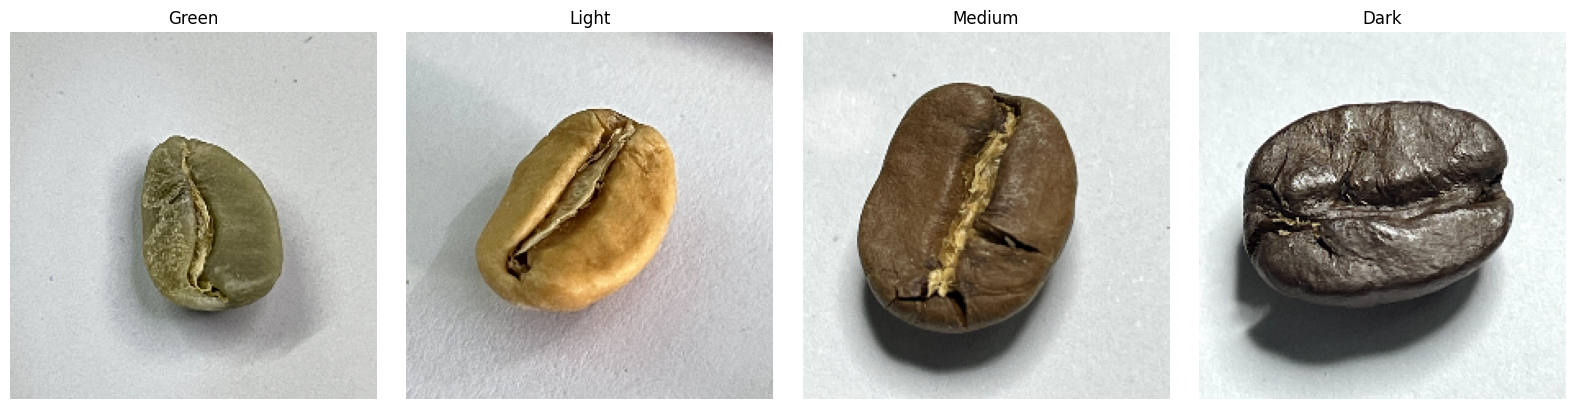

In [6]:
import os, random
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

class_names = ["Green", "Light", "Medium", "Dark"]
target_dir = "/content/data/train"
random.seed(42)
fig, axes = plt.subplots(1, len(class_names), figsize=(4*len(class_names), 4))

for ax, cls in zip(axes, class_names):
    folder = os.path.join(target_dir, cls)
    candidates = [f for f in os.listdir(folder)]
    img_path = os.path.join(folder, random.choice(candidates))
    img = mplimg.imread(img_path)

    ax.imshow(img)
    ax.set_title(f"{cls}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Training The Model

In [7]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [8]:
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
SEED = 42

train_dir = "/content/data/train"
test_dir  = "/content/data/test"
val_dir = "/content/data/val"

#Creating da datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, label_mode="categorical", image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, label_mode="categorical", image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, label_mode="categorical", image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=False, seed=SEED
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Found 1200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.


Minor Augmentations

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.08),
], name="augmentation")

Compiling Model

In [10]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image")
x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input, name="resnet50_preproc")(x)

base = ResNet50(weights="imagenet", include_top=False, input_tensor=x)
base.trainable = False  # Freeze the base

y = layers.GlobalAveragePooling2D()(base.output)
y = layers.Dropout(0.25)(y)
outputs = layers.Dense(NUM_CLASSES, activation="softmax",
                       kernel_regularizer=regularizers.l2(1e-4))(y)
model = models.Model(inputs, outputs, name="ResNet50_coffee")

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
    loss=loss,
    metrics=["accuracy"]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50_coffee"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_preproc    │ (None, 224, 224,  │          0 │ augmentation[0][… │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ resnet50_preproc… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model Callback

In [11]:
cbs = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("resnet50_coffee.keras", monitor="val_loss", save_best_only=True)
]

Model Training

In [12]:
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=5, callbacks=cbs, verbose=1
)

base.trainable = True # Unfreeze

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=loss,
    metrics=["accuracy"]
)

# Finish training all layers

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=30, callbacks=cbs, verbose=1
)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.6382 - loss: 1.1078 - val_accuracy: 0.9850 - val_loss: 0.3229 - learning_rate: 0.0030
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9673 - loss: 0.3529 - val_accuracy: 0.9450 - val_loss: 0.3632 - learning_rate: 0.0030
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9784 - loss: 0.3128 - val_accuracy: 0.9600 - val_loss: 0.3026 - learning_rate: 0.0030
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9884 - loss: 0.2908 - val_accuracy: 0.9750 - val_loss: 0.2895 - learning_rate: 0.0030
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9831 - loss: 0.2887 - val_accuracy: 1.0000 - val_loss: 0.2773 - learning_rate: 0.0030
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.9204 - loss: 0.4910 - val_accuracy: 0.6500 - val_loss: 1.9473 - learning_rate: 3.0000e-04
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.9677 - loss: 0.3522 - va

Evaluate on Test Set

In [13]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0).argmax(axis=1)
y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)

#Confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=NUM_CLASSES).numpy()
print("Class names:", class_names)
print("Confusion matrix:\n", cm)

Test accuracy: 1.0000
Class names: ['Dark', 'Green', 'Light', 'Medium']
Confusion matrix:
 [[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]


Save model

In [18]:
model.save_weights("resnet50_coffee_final.keras")